## Wildfire Recognition Modelling

<h1>Inhaltsverzeichnis</h1>
<ul>
    <li><a href="#Wildfire-Recognition-Modelling">Wildfire Recognition Modelling</a></li>
    <ul>
        <li><a href="#Hilfsfunktionen">Hilfsfunktionen</a></li>
        <li><a href="#Einführung-und-Setup">Einführung und Setup</a></li>
        <li><a href="#1-Daten-laden">1. Daten laden</a></li>
        <li><a href="#2-Daten-visualisieren">2. Daten visualisieren</a></li>
        <li><a href="#3-Modell-definieren">3. Modell definieren</a></li>
        <ul>
            <li><a href="#3.1-Basis-Modell">3.1 Basis-Modell</a></li>
            <li><a href="#3.2-Basis-Modell_Lernrate_anpassen">3.2 Basis-Modell + Lernrate anpassen</a></li>
            <li><a href="#3.3-Mehr-Schichten">3.3 Mehr Schichten</a></li>
            <li><a href="#3.4-Andere-Aktivierung_1">3.4 Andere Aktivierung - LeakyReLu</a></li>
            <li><a href="#3.5-Andere-Aktivierung_2">3.5 Andere Aktivierung - ELU</a></li>
        </ul>
        <li><a href="#4-Modell-trainieren">4. Modell trainieren</a></li>
        <li><a href="#5-Ergebnisse-visualisieren">5. Ergebnisse visualisieren</a></li>
        <li><a href="#6-Modell-speichern">6. Modell speichern</a></li>
    </ul>
<li><a href="#Verbesserungsideen">Verbesserungsideen</a></li>

### <a id="Hilfsfunktionen"></a>Hilfsfunktionen

In [2]:
from pathlib import Path

def find_project_root(start_path: Path, root_name: str = "f.l.a.m.e") -> Path:
    """
    Suche den Projekt-Root-Ordner (z. B. 'f.l.a.m.e'), indem du die Hierarchie nach oben gehst.
    :param start_path: Pfad, von dem aus die Suche beginnt
    :param root_name: Name des Root-Ordners
    :return: Der Pfad zum Projekt-Root
    """
    current_path = start_path.resolve()
    while current_path.name != root_name:
        if current_path.parent == current_path:  # Root des Dateisystems erreicht
            raise FileNotFoundError(f"Projekt-Root '{root_name}' wurde nicht gefunden.")
        current_path = current_path.parent
    return current_path


### <a id="Einführung-und-Setup"></a>Einführung und Setup

In [3]:
# Notebook für Waldbrand-Modellierung
# Importiere die notwendigen Bibliotheken
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

# Bibliotheken für Dateioperationen
from pathlib import Path
import logging
import sys
import os

# Projekt-Root dynamisch ermitteln
PROJECT_ROOT = Path.cwd().parent  # Falls Notebook in einem Unterverzeichnis liegt
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))  # Projekt-Root zu sys.path hinzufügen

# Wichtige Verzeichnisse definieren
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed" / "Wildfire"
SAVED_MODEL_DIR = PROJECT_ROOT / "saved_model"
LOG_DIR = PROJECT_ROOT / "results" / "logs"
LOG_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE = LOG_DIR / "project.log"

# Logger erstellen
log = logging.getLogger(__name__)  # Logger für dieses Modul
log.setLevel(logging.INFO)  # Log-Level festlegen

# FileHandler erstellen
file_handler = logging.FileHandler(LOG_FILE)
file_handler.setLevel(logging.INFO)

# StreamHandler erstellen (für Konsole)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)

# Format festlegen
formatter = logging.Formatter(
    "%(asctime)s - %(name)s - [Line: %(lineno)d] - %(levelname)s - %(message)s"
)
file_handler.setFormatter(formatter)
stream_handler.setFormatter(formatter)

# Handler zum Logger hinzufügen (falls noch nicht vorhanden)
if not log.handlers:  # Verhindert doppelte Logs
    log.addHandler(file_handler)
    log.addHandler(stream_handler)

log.propagate = False  # Verhindere, dass Logs an den Parent-Logger weitergegeben werden

# Verzeichnisse prüfen und ausgeben
log.info(f"Projekt-Root: {PROJECT_ROOT}")
log.info(f"Datenverzeichnis: {PROCESSED_DATA_DIR}")
log.info(f"Modellverzeichnis: {SAVED_MODEL_DIR}")
log.info(f"Log-Verzeichnis: {LOG_DIR}")


2025-01-07 15:15:30,212 - __main__ - [Line: 55] - INFO - Projekt-Root: /Users/peer/Documents/GITLAB_1/6_wiSe24_25/f.l.a.m.e
2025-01-07 15:15:30,213 - __main__ - [Line: 56] - INFO - Datenverzeichnis: /Users/peer/Documents/GITLAB_1/6_wiSe24_25/f.l.a.m.e/data/processed/Wildfire
2025-01-07 15:15:30,213 - __main__ - [Line: 57] - INFO - Modellverzeichnis: /Users/peer/Documents/GITLAB_1/6_wiSe24_25/f.l.a.m.e/saved_model
2025-01-07 15:15:30,213 - __main__ - [Line: 58] - INFO - Log-Verzeichnis: /Users/peer/Documents/GITLAB_1/6_wiSe24_25/f.l.a.m.e/results/logs


### <a id="1-Daten-laden"></a>1. Daten laden

In [4]:
# Überprüfen, ob das Datenverzeichnis existiert
if not PROCESSED_DATA_DIR.exists():
    raise FileNotFoundError(f"Datenverzeichnis {PROCESSED_DATA_DIR} nicht gefunden!")

# Trainings- und Validierungsdatensätze erstellen
train_dataset = image_dataset_from_directory(
    PROCESSED_DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_dataset = image_dataset_from_directory(
    PROCESSED_DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

# Klassennamen anzeigen
class_names = train_dataset.class_names
log.info(f"2 Klassen vorhanden: {class_names}")


Found 36549 files belonging to 2 classes.
Using 29240 files for training.
Found 36549 files belonging to 2 classes.
Using 7309 files for validation.


2025-01-07 15:15:33,385 - __main__ - [Line: 26] - INFO - 2 Klassen vorhanden: ['nowildfire', 'wildfire']


### <a id="2-Daten-visualisieren"></a>2. Daten visualisieren

2025-01-07 15:15:34.903120: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


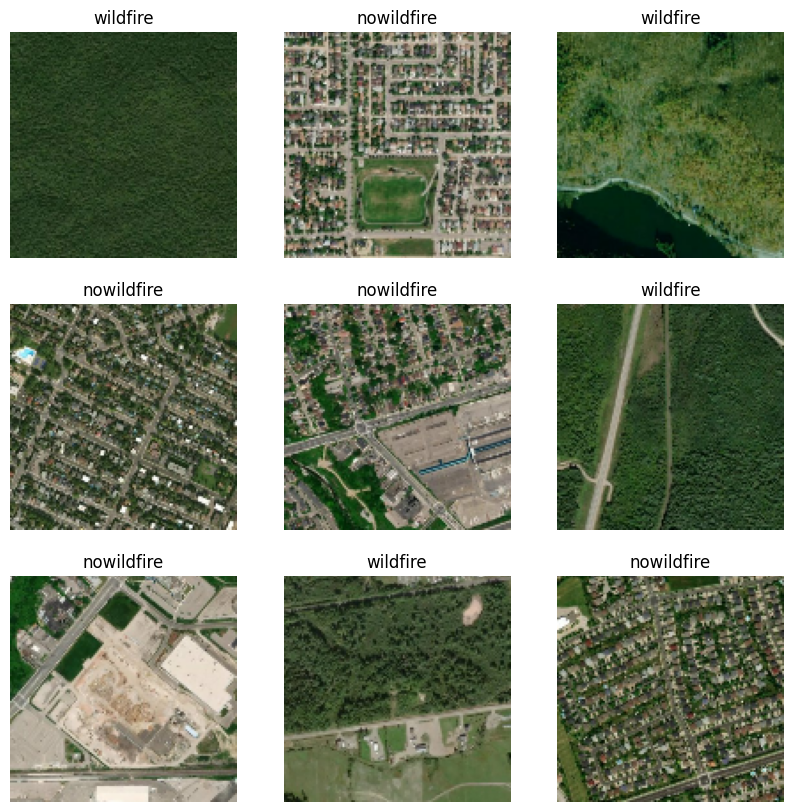

In [5]:
# Beispiel-Bilder aus dem Trainingsdatensatz anzeigen
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### <a id="3-Modell-definieren"></a>3 Modell definieren

<li><a href="#3-Modell-definieren">3. Modell definieren</a></li>
<ul>
    <li><a href="#3.1-Basis-Modell">3.1 Basis-Modell</a></li>
    <li><a href="#3.2-Basis-Modell_Lernrate_anpassen">3.2 Basis-Modell + Lernrate anpassen</a></li>
    <li><a href="#3.3-Mehr-Schichten">3.3 Mehr Schichten</a></li>
    <li><a href="#3.4-Andere-Aktivierung_1">3.4 Andere Aktivierung - LeakyReLu</a></li>
    <li><a href="#3.5-Andere-Aktivierung_2">3.5 Andere Aktivierung - ELU</a></li>
</ul>

### <a id="3.1-Basis-Modell"></a>3.1 Basis-Modell definieren

In [6]:
def build_base_model(input_shape=(128, 128, 3), num_classes=len(class_names)):
    """
    Baut ein CNN-Modell für die Bildklassifikation.
    :param input_shape: Eingabegröße der Bilder
    :param num_classes: Anzahl der Klassen
    :return: Kompiliertes Modell
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Modell erstellen und Zusammenfassung anzeigen
base_model = build_base_model()
base_model.summary()


/Users/peer/Documents/GITLAB_1/6_wiSe24_25/f.l.a.m.e/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### <a id="3.2-Basis-Modell_Lernrate_anpassen"></a>3.2 Basis-Modell + Lernrate anpassen

### <a id="3.3-Mehr-Schichten"></a>3.3 Mehr Schichten

### <a id="3.4-Andere-Aktivierung_1"></a>3.4 Andere Aktivierung - LeakyReLu

### <a id="3.5-Andere-Aktivierung_2"></a>3.5 Andere Aktivierung - ELU

### <a id="4-Modell-trainieren"></a>4. Modell trainieren + speichern

In [8]:
base_models_config = [
    {"name": "model_3_epochs", "epochs": 3},
    {"name": "model_5_epochs", "epochs": 5},
    {"name": "model_10_epochs", "epochs": 10},
    {"name": "model_20_epochs", "epochs": 20}
]

#### <a id="4.1-Trainingsloop-für-Epochenvariation"></a>4.1 Trainingsloop für Epochenvariation

In [ ]:
for config in base_models_config:
    model_name = config["name"]
    epochs = config["epochs"]

    # Modell erstellen
    model = build_base_model()

    # Modell trainieren
    log.info(f"Training {model_name} für {epochs} Epochen...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs
    )

    # Trainings- und Validierungsgenauigkeit protokollieren
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    log.info(f"{model_name} - Trainingsgenauigkeit: {train_acc[-1]:.2f}")
    log.info(f"{model_name} - Validierungsgenauigkeit: {val_acc[-1]:.2f}")

    # Modell speichern
    model_path = SAVED_MODEL_DIR / f"{model_name}.h5"
    model.save(model_path)

    # Klassennamen speichern
    class_names_path = SAVED_MODEL_DIR / f"{model_name}_class_names.txt"
    with open(class_names_path, "w") as f:
        f.writelines("\n".join(class_names))

    log.info(f"{model_name} erfolgreich gespeichert unter {model_path}")

#### Einzeltraining

In [9]:
# Modell trainieren
history = base_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # maximale Anzahl an Epochen
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
        ]
)

# Trainings- und Validierungsgenauigkeit ausgeben
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
log.info(f"Trainingsgenauigkeit: {train_acc[-1]:.2f}")
log.info(f"Validierungsgenauigkeit: {val_acc[-1]:.2f}")

# Modell und Klassennamen speichern
SAVED_MODEL_DIR.mkdir(parents=True, exist_ok=True)
base_model.save(SAVED_MODEL_DIR / f"base_model_with_early_stopping_and_restore_best_weight.h5")

with open(SAVED_MODEL_DIR / "class_names.txt", "w") as f:
    f.writelines("\n".join(class_names))

log.info("Modell und Klassennamen erfolgreich gespeichert.")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2763945755.py, line 5)

### <a id="5-Ergebnisse-visualisieren"></a>5. Ergebnisse visualisieren

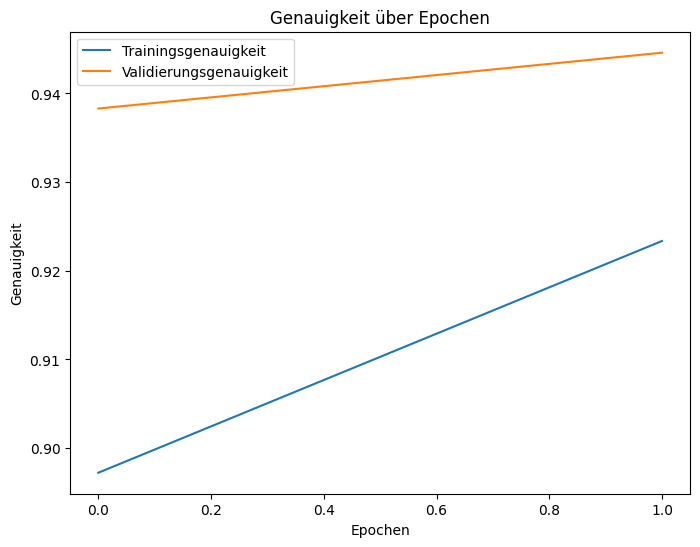

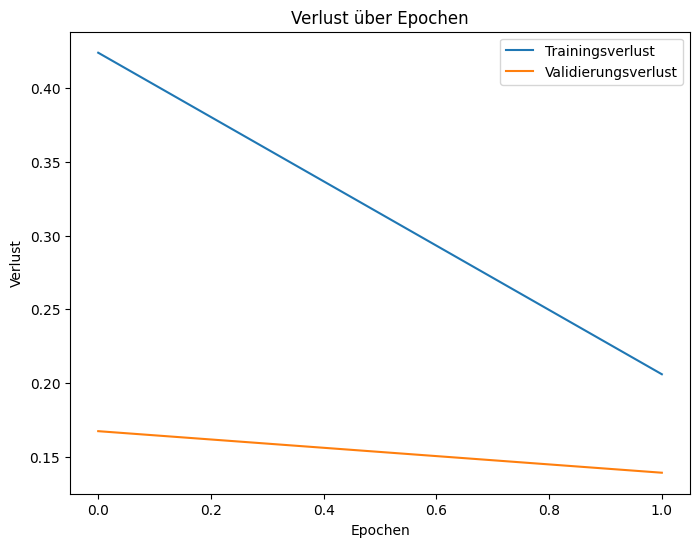

In [32]:
# Lernkurven plotten
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Genauigkeit über Epochen')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()
plt.show()

# Validierungsverlust plotten
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.title('Verlust über Epochen')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()
plt.show()


# <a id="Verbesserungsideen"></a>Verbesserungsideen


<h1>Verbesserungsideen für das Training</h1>
<ul>
    <li><a href="#frühes-stoppen-mit-earlystopping">Frühes Stoppen mit EarlyStopping</a></li>
    <li><a href="#optimale-gewichte-wiederherstellen">Optimale Gewichte wiederherstellen</a></li>
    <li><a href="#lernkurven-analyse">Lernkurven analysieren</a></li>
    <li><a href="#zeit-und-rechenressourcen-sparen">Zeit und Rechenressourcen sparen</a></li>
</ul>

<h2 id="frühes-stoppen-mit-earlystopping">Frühes Stoppen mit EarlyStopping</h2>
<p>
    Mit dem <code>EarlyStopping</code>-Callback kannst du das Training automatisch stoppen, wenn sich eine überwachte Metrik (z. B. <code>val_loss</code>) über mehrere Epochen nicht verbessert. 
    Dies verhindert unnötiges Overfitting und spart Ressourcen.
</p>
<pre><code>
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',         # Überwachte Metrik
    patience=3,                 # Warte 3 Epochen auf Verbesserung
    restore_best_weights=True   # Wiederherstellung der besten Gewichte
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)
</code></pre>

<h2 id="optimale-gewichte-wiederherstellen">Optimale Gewichte wiederherstellen</h2>
<p>
    Durch die Option <code>restore_best_weights=True</code> kannst du sicherstellen, dass das Modell auf die besten Gewichte während des Trainings zurückgesetzt wird. 
    Dies ist besonders nützlich, wenn das Modell in späteren Epochen überanpasst wird.
</p>
<pre><code>
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)
</code></pre>

<h2 id="lernkurven-analyse">Lernkurven analysieren</h2>
<p>
    Um den Fortschritt des Trainings und die Wirkung von EarlyStopping zu visualisieren, kannst du die Lernkurven (Genauigkeit und Verlust) plotten.
    Dies hilft dir, den optimalen Zeitpunkt des Stopps zu bewerten.
</p>
<pre><code>
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Genauigkeit über Epochen')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()
plt.show()
</code></pre>

<h2 id="zeit-und-rechenressourcen-sparen">Zeit und Rechenressourcen sparen</h2>
<p>
    Durch die Kombination von <code>EarlyStopping</code> und einer gezielten Analyse der Trainingsmetriken kannst du die Trainingszeit verkürzen und deine Rechenressourcen optimal nutzen. 
    Das Modell wird nur so lange trainiert, wie es tatsächlich Fortschritte macht.
</p>

<pre><code>
# Maximale Epochen festlegen
max_epochs = 50



# Modell trainieren
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=max_epochs,
    callbacks=[early_stopping]
)

print(f"Das Training wurde nach {len(history.history['accuracy'])} Epochen gestoppt.")
</code></pre>

